Activate the project

In [1]:
using Pkg
Pkg.activate(".")

  Activating environment at `/media/labfiles/nsom/repos/kp-lflm-group/src/KPpack/Project.toml`


# Load the package KPpack

In [2]:
using KPpack

## test the bulk calculation

In [3]:
material="GaAs"; Temp=0; soc=true;
tipo="KaneII";
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

mm=KPpack.Materials(material,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0);
KPpack.ParMat(mm,Temp)
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
pl=1; pm=0; pn=0; kmax= 0.32; Nt=100;
Ex, Kx =KPpack.DiagM(mm,kmax,Nt,pl,pm,pn,soc,tipo);
#L
pl=1; pm=1; pn=1; kmax= 0.2; Nt=100;
El, Kl =KPpack.DiagM(mm,kmax,Nt,pl,pm,pn,soc,tipo);

#++++++++++++++++++++++++
K=vcat(-1*Kl,Kx); E=vcat(El,Ex);
EDOS, aDOS = KPpack.DOS(-2,2.2,0.01,E,0.04);

# Plot band diagram

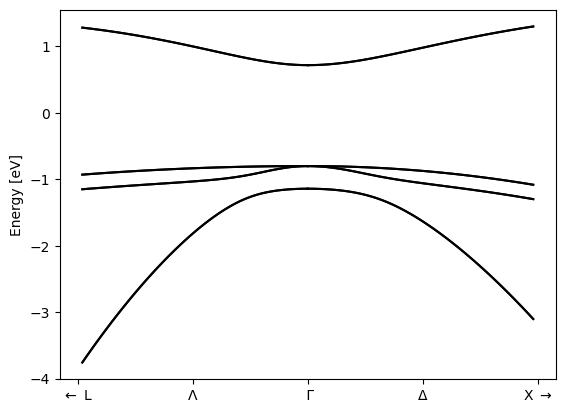

In [4]:
KPpack.PlotBands(Ex,El,Kx,Kl);

# Plot DOS

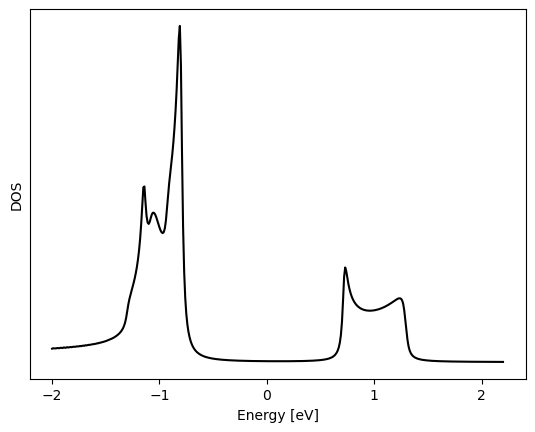

In [5]:
KPpack.PlotDOS(EDOS,aDOS);

# Make a structure

In [6]:
nlayer=5; Npts=100
layer=Array{KPpack.mat}(undef,nlayer)

layer[1]=KPpack.mat("GaAs",70);
layer[2]=KPpack.mat("AlGaAs_0.25",30);
layer[3]=KPpack.mat("GaAs",6);
#layer[4]=KPpack.mat("AlGaAs_0.1",6);
#layer[5]=KPpack.mat("GaAs",13);
layer[4]=KPpack.mat("AlGaAs_0.25",30);
layer[5]=KPpack.mat("GaAs",70);


X,boundary =KPpack.mesh(Npts,layer,nlayer);
mlayer=Array{KPpack.Materials}(undef, length(X));

boundPoints=KPpack.supParams(layer,X,boundary,mlayer,Temp);

# Plot structure

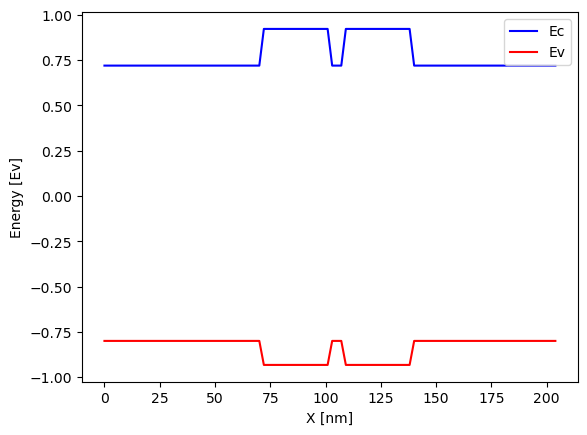

In [7]:
kind="both"
KPpack.plotProf(mlayer,X,kind);

## find eigenvalues solving for K=0

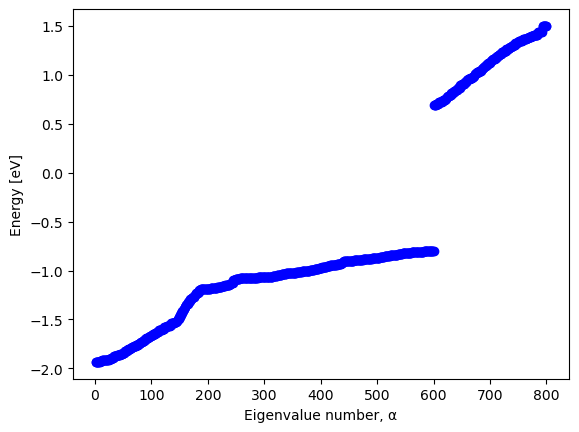

  7.913315 seconds (9.81 M allocations: 1.235 GiB, 3.92% gc time, 56.67% compilation time)


In [8]:
c=0.038; cps=2.0; dx=X[2]-X[1]

@time Eqw0, EVqw0=KPpack.EigSolQW(mlayer,Npts,boundPoints,c,cps,dx);
KPpack.PloteigvQW(Npts,Eqw0);

# QW Band Structure Calculation

In [9]:
kmax= 0.1; Nt=50;
n=20
sV=-0.802; sC=0.5

pl=1; pm=1;
@time Ecq11,Evq11,Kqw11 =KPpack.DiagQWM(mlayer,kmax,Nt,dx,pl,pm,Npts,boundPoints,n,c,cps,sV,sC );

pl=1; pm=0;
@time Ecq10,Evq10,Kqw10 =KPpack.DiagQWM(mlayer,kmax,Nt,dx,pl,pm,Npts,boundPoints,n,c,cps,sV,sC );

 24.907906 seconds (70.68 M allocations: 38.029 GiB, 11.32% gc time, 13.91% compilation time)
 16.509301 seconds (64.71 M allocations: 37.676 GiB, 13.33% gc time)


## Valence Band 

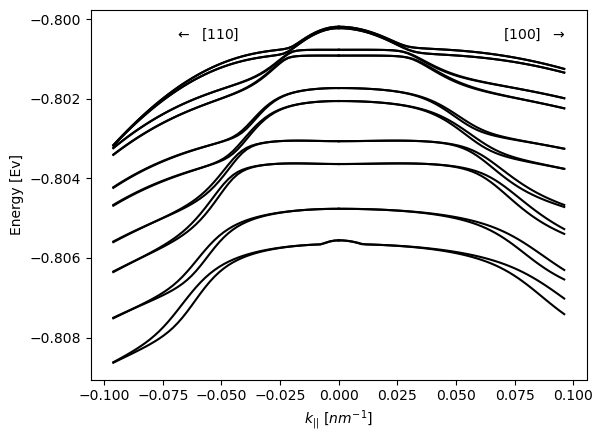

In [17]:
option="complete_V"; poslab=-0.8005
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,poslab);

## Conduction Band

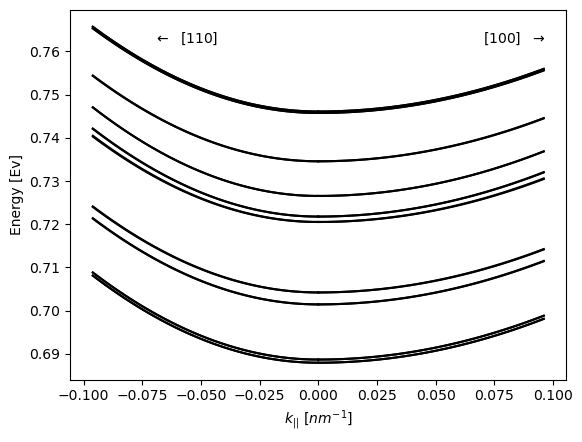

In [15]:
option="complete_C"; poslab=0.762
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,poslab);

# DOS QW

## DOS Valence Band

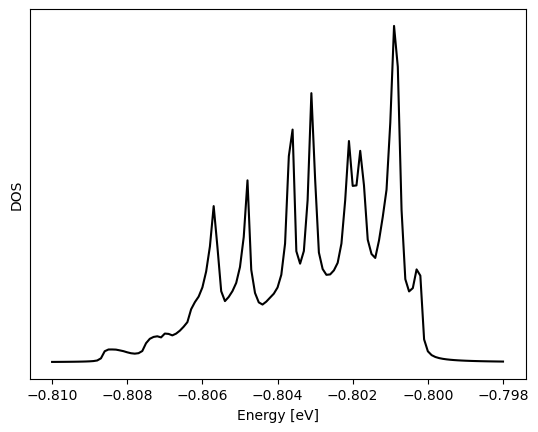

In [12]:
Evqw= vcat(Evq11,Evq10);
EDOSv, aDOSv = KPpack.DOS(-0.81,-0.798,0.0001,Evqw,1e-4);
KPpack.PlotDOS(EDOSv,aDOSv);

## DOS Conduction Band

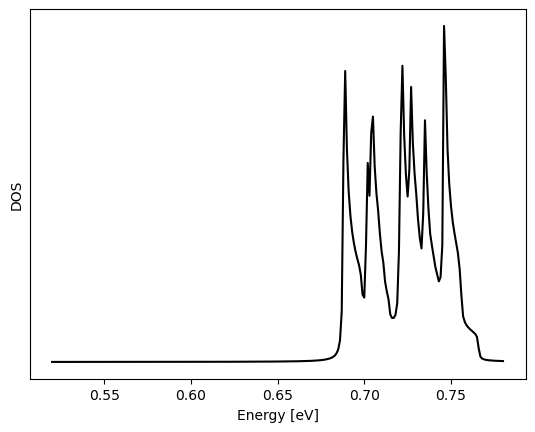

In [13]:
Evqw= vcat(Ecq11,Ecq10);
EDOSc, aDOSc = KPpack.DOS(0.52,0.78,0.001,Evqw,1e-3);
KPpack.PlotDOS(EDOSc,aDOSc);

save a file with band structure

In [14]:
# save a file in folder data with a name given by the user
Exr=vcat(transpose(Kx),transpose(Ex))'
el=vcat(transpose(-1*Kl),transpose(El))'
Elr=rotl90(el,3)';
dat=vcat(Elr,Exr);
name="BandStructure_GaAs_1"
KPpack.writefile(dat,name)